In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras

In [2]:
df_train_full = pd.read_csv('../data/train.csv', dtype={'Id': str})
df_train_full['filename'] = '../data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,../data/images/0560.jpg
1,4675,cup,../data/images/4675.jpg
2,0875,glass,../data/images/0875.jpg
3,4436,spoon,../data/images/4436.jpg
4,8265,plate,../data/images/8265.jpg


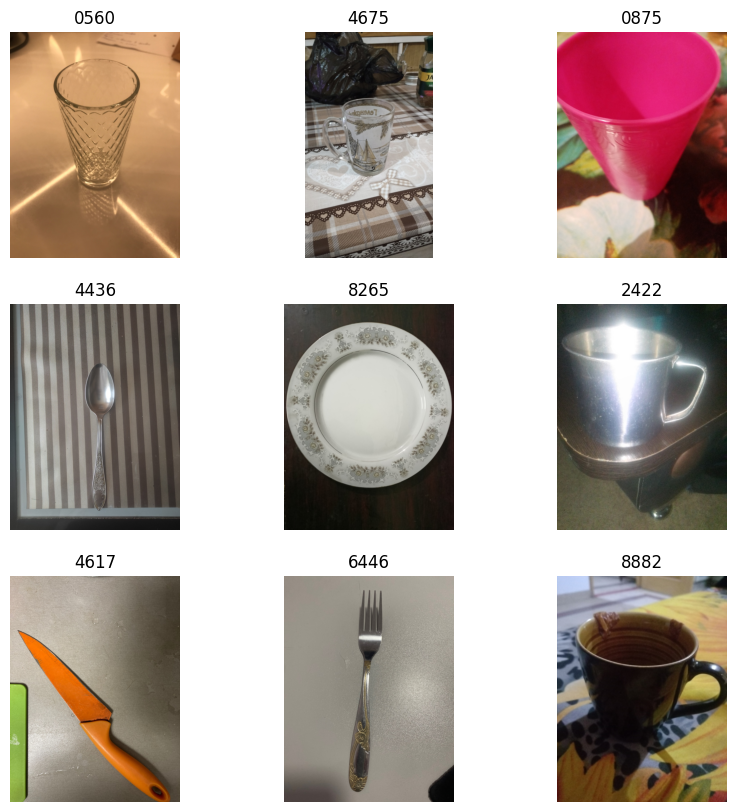

In [3]:
## Visualizing the data

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(df_train_full['filename'][i])
    plt.imshow(img)
    plt.title(df_train_full['Id'][i])
    plt.axis('off')

In [4]:
## Split the data
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

In [5]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#Preprocess using transfer learning 
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [7]:
## Train generator class-indices
train_generator.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [8]:
## I'll use this model as a base model, I'll try to improve the accuracy of this model.
def make_model(lr= 0.01):
    base_model = Xception(
        weights = 'imagenet',
        include_top = False,
        input_shape = (150,150,3)
    )
    base_model.trainable = False 
    inputs = keras.Input(shape = (150,150,3))
    base = base_model(inputs, training = False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs = inputs, outputs = outputs)

    
    optimizers = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer = optimizers, loss = loss, metrics = ['accuracy'])
    return model

## Learning rate
Trying different values

In [10]:
scores = {}

for lr in [0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(lr = lr)
    history = model.fit(train_generator, epochs = 10, validation_data = val_generator)
    scores[lr] = history.history
    
    print()
    print()

0.001
Epoch 1/10
139/139 [==============================] - 242s 2s/step - loss: 0.4975 - accuracy: 0.8192 - val_loss: 0.3447 - val_accuracy: 0.8804
Epoch 2/10
139/139 [==============================] - 208s 1s/step - loss: 0.2849 - accuracy: 0.9031 - val_loss: 0.3282 - val_accuracy: 0.8840
Epoch 3/10
139/139 [==============================] - 202s 1s/step - loss: 0.2257 - accuracy: 0.9215 - val_loss: 0.2950 - val_accuracy: 0.8975
Epoch 4/10
139/139 [==============================] - 193s 1s/step - loss: 0.1909 - accuracy: 0.9323 - val_loss: 0.2877 - val_accuracy: 0.8957
Epoch 5/10
139/139 [==============================] - 202s 1s/step - loss: 0.1669 - accuracy: 0.9474 - val_loss: 0.3063 - val_accuracy: 0.8795
Epoch 6/10
139/139 [==============================] - 204s 1s/step - loss: 0.1429 - accuracy: 0.9573 - val_loss: 0.2871 - val_accuracy: 0.8948
Epoch 7/10
139/139 [==============================] - 214s 2s/step - loss: 0.1270 - accuracy: 0.9615 - val_loss: 0.3009 - val_accuracy: 

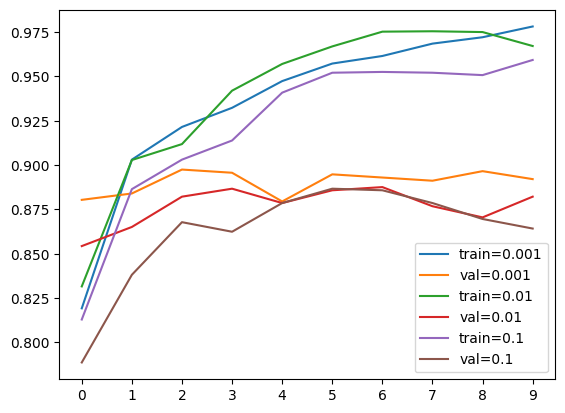

In [12]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [13]:
## Following the grapich, we can select lr = 0.001

lr = 0.001

## Adding more layers
Trying different approaches in order to improve the accuracy

In [15]:
def make_model_inner(lr= 0.001, size_inner = 100):
    base_model = Xception(
        weights = 'imagenet',
        include_top = False,
        input_shape = (150,150,3)
    )
    base_model.trainable = False 
    inputs = keras.Input(shape = (150,150,3))
    base = base_model(inputs, training = False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation = 'relu')(vectors)
    outputs = keras.layers.Dense(6)(inner)
    model = keras.Model(inputs = inputs, outputs = outputs)

    
    optimizers = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer = optimizers, loss = loss, metrics = ['accuracy'])
    return model

In [18]:
## Trying different sizes for the inner layer
scores = {}

for size in [10,100,1000]:
    print(size)

    model = make_model_inner(lr=lr, size_inner=size)
    history = model.fit(train_generator, epochs = 10, validation_data = val_generator)
    scores[size] = history.history

    print()
    print()
    

10
Epoch 1/10
139/139 [==============================] - 203s 1s/step - loss: 0.5329 - accuracy: 0.8192 - val_loss: 0.3422 - val_accuracy: 0.8804
Epoch 2/10
139/139 [==============================] - 188s 1s/step - loss: 0.2792 - accuracy: 0.9004 - val_loss: 0.2975 - val_accuracy: 0.8930
Epoch 3/10
139/139 [==============================] - 187s 1s/step - loss: 0.2245 - accuracy: 0.9206 - val_loss: 0.2897 - val_accuracy: 0.9011
Epoch 4/10
139/139 [==============================] - 186s 1s/step - loss: 0.1846 - accuracy: 0.9350 - val_loss: 0.3002 - val_accuracy: 0.8957
Epoch 5/10
139/139 [==============================] - 188s 1s/step - loss: 0.1532 - accuracy: 0.9514 - val_loss: 0.2945 - val_accuracy: 0.8993
Epoch 6/10
139/139 [==============================] - 244s 2s/step - loss: 0.1274 - accuracy: 0.9613 - val_loss: 0.3006 - val_accuracy: 0.8957
Epoch 7/10
139/139 [==============================] - 204s 1s/step - loss: 0.1138 - accuracy: 0.9649 - val_loss: 0.3033 - val_accuracy: 0.8

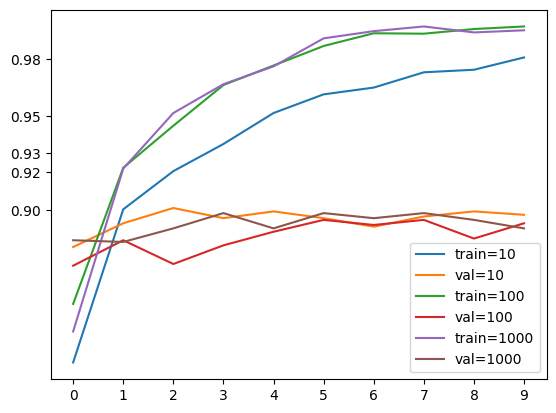

In [21]:
for size, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % size))
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.90, 0.92, 0.93, 0.95, 0.98])
plt.legend()

# It looks like val=1000 is the best, but it's overfitting, same for val=100
# Let's try val=10

## Regularization and dropout

In [25]:
val = 10

def make_model_inner_drop(lr= 0.001, size_inner = 10, droprate = 0.5):
    base_model = Xception(
        weights = 'imagenet',
        include_top = False,
        input_shape = (150,150,3)
    )
    base_model.trainable = False 
    inputs = keras.Input(shape = (150,150,3))
    base = base_model(inputs, training = False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation = 'relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(6)(drop)
    model = keras.Model(inputs = inputs, outputs = outputs)

    
    optimizers = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer = optimizers, loss = loss, metrics = ['accuracy'])
    return model

In [27]:
scores = {}

for droprate in [0.1, 0.2, 0.3, 0.4, 0.5]:

    print(droprate)

    model = make_model_inner_drop(lr=lr, size_inner=val, droprate=droprate)
    history = model.fit(train_generator, epochs = 5, validation_data = val_generator)
    scores[droprate] = history.history

    print()
    print()

0.1
Epoch 1/5
139/139 [==============================] - 174s 1s/step - loss: 0.7048 - accuracy: 0.7374 - val_loss: 0.3774 - val_accuracy: 0.8831
Epoch 2/5
139/139 [==============================] - 160s 1s/step - loss: 0.4233 - accuracy: 0.8383 - val_loss: 0.3340 - val_accuracy: 0.8813
Epoch 3/5
139/139 [==============================] - 161s 1s/step - loss: 0.3302 - accuracy: 0.8750 - val_loss: 0.2927 - val_accuracy: 0.9065
Epoch 4/5
139/139 [==============================] - 161s 1s/step - loss: 0.2745 - accuracy: 0.8957 - val_loss: 0.3062 - val_accuracy: 0.8966
Epoch 5/5
139/139 [==============================] - 160s 1s/step - loss: 0.2428 - accuracy: 0.9110 - val_loss: 0.2893 - val_accuracy: 0.9029


0.2
Epoch 1/5
139/139 [==============================] - 173s 1s/step - loss: 0.8403 - accuracy: 0.6841 - val_loss: 0.4141 - val_accuracy: 0.8687
Epoch 2/5
139/139 [==============================] - 187s 1s/step - loss: 0.4770 - accuracy: 0.8340 - val_loss: 0.3197 - val_accuracy: 0.8

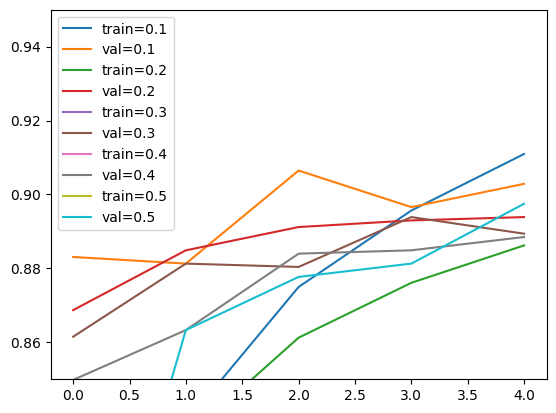

In [29]:
for droprate, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % droprate))
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.85, 0.95)
plt.legend()

## It looks like droprate = 0.1 is the best

In [31]:
droprate = 0.1

## Last model

model = make_model_inner_drop(lr=lr, size_inner=val, droprate=droprate)
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_v2_{epoch:02d}_{val_accuracy:.3f}.h5',
    monitor='val_accuracy',
    save_best_only = True,
    mode = 'max'
)

history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    callbacks = [checkpoint]
)

## Let's see the results

Epoch 1/10
139/139 [==============================] - 190s 1s/step - loss: 0.6567 - accuracy: 0.7605 - val_loss: 0.3722 - val_accuracy: 0.8723
Epoch 2/10
139/139 [==============================] - 182s 1s/step - loss: 0.3605 - accuracy: 0.8691 - val_loss: 0.3161 - val_accuracy: 0.8885
Epoch 3/10
139/139 [==============================] - 187s 1s/step - loss: 0.3003 - accuracy: 0.8957 - val_loss: 0.3049 - val_accuracy: 0.8930
Epoch 4/10
139/139 [==============================] - 184s 1s/step - loss: 0.2547 - accuracy: 0.9114 - val_loss: 0.3020 - val_accuracy: 0.8957
Epoch 5/10
139/139 [==============================] - 200s 1s/step - loss: 0.2156 - accuracy: 0.9276 - val_loss: 0.2897 - val_accuracy: 0.8957
Epoch 6/10
139/139 [==============================] - 189s 1s/step - loss: 0.1968 - accuracy: 0.9321 - val_loss: 0.3170 - val_accuracy: 0.9020
Epoch 7/10
139/139 [==============================] - 170s 1s/step - loss: 0.1775 - accuracy: 0.9366 - val_loss: 0.3136 - val_accuracy: 0.8984

## Using the model

In [32]:
model = keras.models.load_model('model_v2_06_0.902.h5')

In [33]:
df_test = pd.read_csv('../data/test.csv', dtype = {'Id':str})
df_test['filename'] = '../data/images/' + df_test['Id'] + '.jpg'

df_test.head()

,Id,filename
0,0678,../data/images/0678.jpg
1,3962,../data/images/3962.jpg
2,9271,../data/images/9271.jpg
3,5133,../data/images/5133.jpg
4,8842,../data/images/8842.jpg


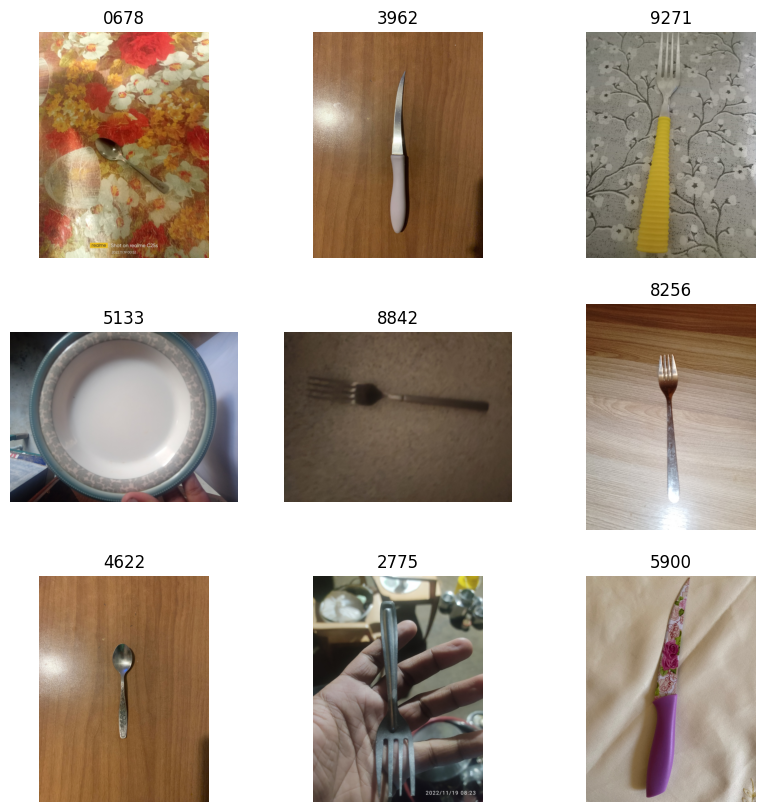

In [34]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(df_test['filename'][i])
    plt.imshow(img)
    plt.title(df_test['Id'][i])
    plt.axis('off')

In [47]:
## Test the model
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    df_test,
    x_col = 'filename',
    class_mode = 'input',
    target_size = (150,150),
    batch_size = 32,
    shuffle = False
)

predictions = model.predict(test_generator)

Found 3808 validated image filenames.
119/119 [==============================] - 113s 946ms/step


In [48]:
## How well did the model?

df_test['Category'] = np.argmax(predictions, axis = 1)

df_test['Category'] = df_test['Category'].map({0:'cup', 1:'fork', 2:'glass', 3:'knife', 4:'plate', 5:'spoon'})

In [49]:
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = df_test['Category']

df_submission['Id'] = df_submission.filename.str[len('../data/images/'):-4]
del df_submission['filename']

In [50]:
df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [51]:
df_test.head()

,Id,filename,Category
0,0678,../data/images/0678.jpg,knife
1,3962,../data/images/3962.jpg,knife
2,9271,../data/images/9271.jpg,knife
3,5133,../data/images/5133.jpg,plate
4,8842,../data/images/8842.jpg,fork


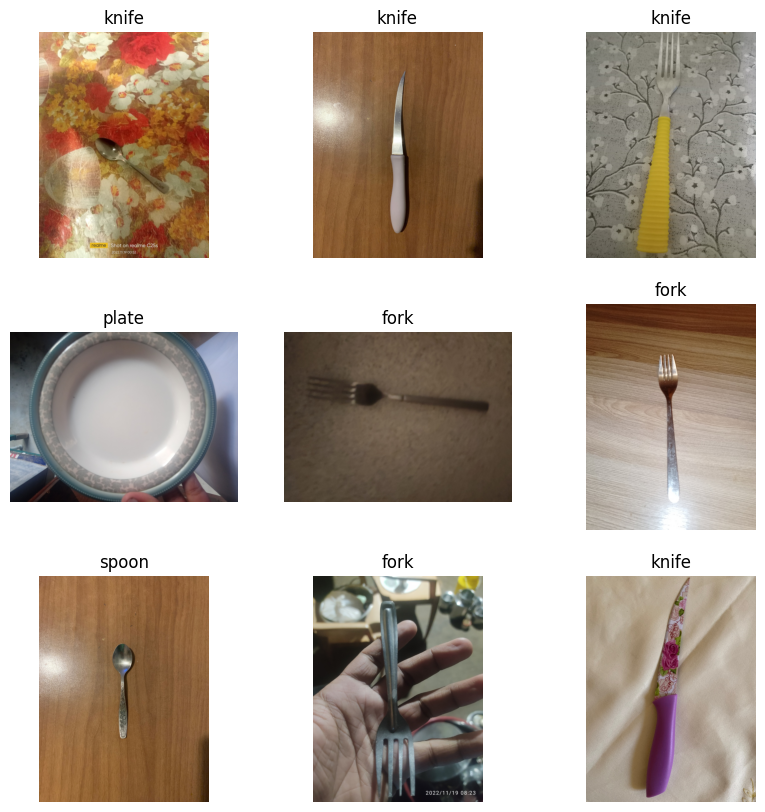

In [52]:
## Plotting some of them with their category

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(df_test['filename'][i])
    plt.imshow(img)
    plt.title(df_test['Category'][i])
    plt.axis('off')

In [53]:
model = keras.models.load_model('model_v2_07_0.903.h5')
def submission_csv():
    predictions = model.predict(test_generator)
    df_test['Category'] = np.argmax(predictions, axis = 1)
    df_test['Category'] = df_test['Category'].map({0:'cup', 1:'fork', 2:'glass', 3:'knife', 4:'plate', 5:'spoon'})
    df_submission = pd.DataFrame()
    df_submission['filename'] = test_generator.filenames
    df_submission['label'] = df_test['Category']
    df_submission['Id'] = df_submission.filename.str[len('../data/images/'):-4]
    del df_submission['filename']
    df_submission[['Id', 'label']].to_csv('submission.csv', index=False)
submission_csv()

    

119/119 [==============================] - 108s 899ms/step
